In [1]:
import joblib
import numpy as np
import tensorflow as tf
from garage.sampler.utils import rollout
import time
from mylab.samplers.ast_vectorized_sampler import ASTVectorizedSampler
from garage.tf.algos.batch_polopt import BatchPolopt
from mylab.simulators.example_av_simulator import ExampleAVSimulator
from mylab.rewards.example_av_reward import ExampleAVReward
from mylab.spaces.example_av_spaces import ExampleAVSpaces
import pickle
import numpy.random
import matplotlib.pyplot as plt
import sphviewer as sph
import pdb

In [2]:
with tf.Session() as sess:
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        data = joblib.load('./data/lr_64/l1/itr_1000.pkl')
        

In [13]:
type(data['env'])

garage.tf.envs.base.TfEnv

In [4]:
print(data.keys())

dict_keys(['itr', 'policy', 'baseline', 'env', 'paths'])


In [14]:
dir(data['env'])

['_Serializable__args',
 '_Serializable__kwargs',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_cached_param_dtypes',
 '_cached_param_shapes',
 '_cached_params',
 '_close_mjviewer_window',
 '_serializable_initialized',
 '_to_garage_space',
 'action_space',
 'class_name',
 'clone',
 'close',
 'compute_reward',
 'env',
 'flat_to_params',
 'get_param_dtypes',
 'get_param_shapes',
 'get_param_values',
 'get_params',
 'get_params_internal',
 'horizon',
 'log_diagnostics',
 'max_episode_steps',
 'metadata',
 'observation_space

In [133]:
type(data['itr'])

int

In [19]:
type(data['paths'])

list

In [72]:
dir(data['env'].wrapped_env.wrapped_env)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_action',
 '_actions',
 '_done',
 '_first_step',
 '_info',
 '_init_state',
 '_reward',
 '_sample_init_state',
 '_step',
 'action_dim',
 'action_only',
 'action_space',
 'get_cache_list',
 'get_param_values',
 'horizon',
 'log',
 'log_diagnostics',
 'observation_space',
 'render',
 'reset',
 'reward_function',
 'set_param_values',
 'simulate',
 'simulator',
 'spaces',
 'spec',
 'step',
 'terminate']

In [64]:
with tf.Session() as sess:
    with tf.variable_scope('Loader', reuse=True):
        data = joblib.load('./data/debug/d_gen7/itr_990.pkl')
        start = time.clock()
        for i in range(200):
            x = rollout(data['env'],data['policy'], max_path_length=50, animated=False, speedup=1,always_return_paths=False)
        print(time.clock() - start)
# print(x)

23.791196


In [58]:
print(x.keys())

dict_keys(['actions', 'env_infos', 'rewards', 'agent_infos', 'observations'])


In [3]:
import time
from garage.tf.policies.base import Policy
import tensorflow as tf
from garage.sampler.utils import rollout
from garage.algos import RLAlgorithm
import garage.misc.logger as logger
from garage.tf.plotter import Plotter
from garage.tf.samplers import BatchSampler
from garage.tf.samplers import OnPolicyVectorizedSampler

class BatchPoloptCustom(RLAlgorithm):
    """
    Base class for batch sampling-based policy optimization methods.
    This includes various policy gradient methods like vpg, npg, ppo, trpo, etc.
    """

    def __init__(
            self,
            env,
            policy,
            baseline,
            scope=None,
            n_itr=500,
            start_itr=0,
            batch_size=5000,
            max_path_length=500,
            discount=0.99,
            gae_lambda=1,
            plot=False,
            pause_for_plot=False,
            center_adv=True,
            positive_adv=False,
            store_paths=False,
            whole_paths=True,
            fixed_horizon=False,
            sampler_cls=None,
            sampler_args=None,
            force_batch_sampler=False,
            **kwargs
    ):
        """
        :param env: Environment
        :param policy: Policy
        :type policy: Policy
        :param baseline: Baseline
        :param scope: Scope for identifying the algorithm. Must be specified if running multiple algorithms
        simultaneously, each using different environments and policies
        :param n_itr: Number of iterations.
        :param start_itr: Starting iteration.
        :param batch_size: Number of samples per iteration.
        :param max_path_length: Maximum length of a single rollout.
        :param discount: Discount.
        :param gae_lambda: Lambda used for generalized advantage estimation.
        :param plot: Plot evaluation run after each iteration.
        :param pause_for_plot: Whether to pause before contiuing when plotting.
        :param center_adv: Whether to rescale the advantages so that they have mean 0 and standard deviation 1.
        :param positive_adv: Whether to shift the advantages so that they are always positive. When used in
        conjunction with center_adv the advantages will be standardized before shifting.
        :param store_paths: Whether to save all paths data to the snapshot.
        :return:
        """
        self.env = env
        self.policy = policy
        self.baseline = baseline
        self.scope = scope
        self.n_itr = n_itr
        self.start_itr = start_itr
        self.batch_size = batch_size
        self.max_path_length = max_path_length
        self.discount = discount
        self.gae_lambda = gae_lambda
        self.plot = plot
        self.pause_for_plot = pause_for_plot
        self.center_adv = center_adv
        self.positive_adv = positive_adv
        self.store_paths = store_paths
        self.whole_paths = whole_paths
        self.fixed_horizon = fixed_horizon
        if sampler_cls is None:
            if self.policy.vectorized and not force_batch_sampler:
                sampler_cls = OnPolicyVectorizedSampler
            else:
                sampler_cls = BatchSampler
        if sampler_args is None:
            sampler_args = dict()
        self.sampler = sampler_cls(self, **sampler_args)
        self.init_opt()

    def start_worker(self):
        self.sampler.start_worker()

    def shutdown_worker(self):
        self.sampler.shutdown_worker()

    def obtain_samples(self, itr):
        return self.sampler.obtain_samples(itr)

    def process_samples(self, itr, paths):
        return self.sampler.process_samples(itr, paths)

    def test(self, sess=None, f_checkpoint=None):
        created_session = True if (sess is None) else False
        if sess is None:
            sess = tf.Session()
            sess.__enter__()
            
        sess.run(tf.global_variables_initializer())
        if f_checkpoint is not None:
            saver = tf.train.Saver()
            saver.restore(sess, f_checkpoint)
        self.start_worker()
        start_time = time.time()
        itr_start_time = time.time()
#         logger.log("Obtaining samples...")
        paths = self.obtain_samples(0)
#         logger.log("Processing samples...")
        samples_data = self.process_samples(0, paths)
#         logger.log("Logging diagnostics...")
#         self.log_diagnostics(paths)
#             logger.log("Optimizing policy...")
#             self.optimize_policy(itr, samples_data)
#             logger.log("Saving snapshot...")
#             params = self.get_itr_snapshot(itr, samples_data)  # , **kwargs)
#         if self.store_paths:
#             params["paths"] = samples_data["paths"]
#             logger.save_itr_params(itr, params)
#             logger.log("Saved")
#             logger.record_tabular('Time', time.time() - start_time)
#             logger.record_tabular('ItrTime', time.time() - itr_start_time)
#             logger.dump_tabular(with_prefix=False)
#             if self.plot:
#                 rollout(self.env, self.policy, animated=True, max_path_length=self.max_path_length)
#                 if self.pause_for_plot:
#                     input("Plotting evaluation run: Press Enter to "
#                           "continue...")
        self.shutdown_worker()
        if created_session:
            sess.close()
        return samples_data

    def log_diagnostics(self, paths):
        self.env.log_diagnostics(paths)
        self.policy.log_diagnostics(paths)
        self.baseline.log_diagnostics(paths)

    def init_opt(self):
        """
        Initialize the optimization procedure. If using tensorflow, this may
        include declaring all the variables and compiling functions
        """
        return None

    def get_itr_snapshot(self, itr, samples_data):
        """
        Returns all the data that should be saved in the snapshot for this
        iteration.
        """
        return samples_data

    def optimize_policy(self, itr, samples_data):
        return None



In [4]:
with tf.Session() as sess:
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        data = joblib.load('./data/lr_64/l4/itr_1000.pkl')
        sampler_cls = ASTVectorizedSampler
        env = data['env']
        env.env.env._fixed_init_state = False
        algo = BatchPoloptCustom(
                                env=env,
                                policy=data['policy'],
                                baseline=data['baseline'],
                                batch_size=2500000,
                                step_size=0.0,
                                n_itr=1,
                                store_paths=True,
                                optimizer=None,
                                max_path_length=50,
                                sampler_cls=sampler_cls,
                                sampler_args={"open_loop":True,
                                              "sim": data['env'].env.env.simulator,
                                              "reward_function": data['env'].env.env.reward_function})
        start = time.clock()
        for i in range(1):
            x = algo.test(sess=sess, f_checkpoint = './data/lr_64/l4/model.ckpt')
        print(time.clock() - start)
max(x['rewards'][:,-1])

INFO:tensorflow:Restoring parameters from ./data/lr_64/l4/model.ckpt
2019-01-23 13:32:44 | Obtaining samples for iteration 0...


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:55


2381.35251


0.0

In [9]:
dir(data['env'].env.env)

['_Serializable__args',
 '_Serializable__kwargs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_action',
 '_actions',
 '_done',
 '_first_step',
 '_fixed_init_state',
 '_info',
 '_init_state',
 '_reward',
 '_serializable_initialized',
 '_step',
 '_to_garage_space',
 'action_only',
 'action_space',
 'clone',
 'close',
 'get_cache_list',
 'log',
 'log_diagnostics',
 'metadata',
 'observation_space',
 'open_loop',
 'quick_init',
 'render',
 'reset',
 'reward_function',
 'reward_range',
 'seed',
 'simulate',
 'simulator',
 'spaces',
 'spec',
 'step',
 'unwrapped',
 'vec_env_executor',
 'vectorized']

In [8]:
data['env'].env.env.reset()

array([ 0.09762701, -4.575947  ,  1.2055267 , 11.420672  , 33.66396   ],
      dtype=float32)

In [28]:
type(x['paths'])

list

In [12]:
x['env_infos']['info']['cache'][31][:,:]

array([[ 0.00000000e+00,  0.00000000e+00,  1.06516180e+01,
         0.00000000e+00,  2.85255843e+01,  0.00000000e+00,
         5.70272278e-01,  1.15008959e+00, -1.23478156e-01,
        -3.73192586e+00,  5.70272278e+00,  1.18881143e-01,
        -7.10209331e-01,  1.27862382e+00, -1.41609711e+00,
         1.99160769e+00, -1.89061678e+00],
       [ 0.00000000e+00,  1.00000000e+00,  1.07034562e+01,
         0.00000000e+00,  2.95907461e+01,  0.00000000e+00,
         1.42325866e+00,  1.14426473e+00, -2.38016089e-02,
        -3.61720815e+00,  8.52986380e+00, -5.82485672e-02,
         6.67885501e-02,  2.75087215e+00,  5.31000752e-01,
         3.05090631e+00, -1.98080051e+00],
       [ 0.00000000e+00,  2.00000000e+00,  9.80345620e+00,
         0.00000000e+00,  3.06610917e+01,  0.00000000e+00,
         2.01436198e+00,  1.18005503e+00,  1.48079423e-01,
        -3.50099216e+00,  5.91103325e+00,  3.57902937e-01,
        -1.11828212e+00,  3.61532671e-01,  4.09907060e-01,
         2.05943718e+00, -2.0

In [10]:
x['rewards'][31,:]

array([-1.89061678, -1.98080051, -2.01657666, -1.99129901, -2.29008732,
       -2.03226694, -2.4926948 , -2.29549415, -2.29689476, -2.2320798 ,
       -1.83654553, -2.11974546, -2.07868526, -1.96386307, -2.39982584,
       -2.34695533, -2.54305589, -1.95019101, -2.55195449, -2.52689697,
       -1.87312727, -2.51262621, -2.02232395, -2.20194907, -2.54364932,
       -2.09961993, -1.80082314, -1.93002197, -2.17451047, -2.15098742,
       -1.86914637, -2.20538394, -2.52967017, -1.85219098, -2.51496018,
       -2.31102959, -2.03842864, -1.94326007, -1.93118238, -2.3046576 ,
       -1.8299369 , -1.9203184 , -2.18086903, -2.54477163, -2.55606432,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [5]:
print(np.min(x['observations'][:,0,:], axis=0))
print(np.max(x['observations'][:,0,:], axis=0))

[-9.9997294e-01 -5.9997830e+00  1.4388702e-04  8.3775816e+00
  2.6250511e+01]
[ 0.99997926 -1.0000166   1.9999266  13.962494   43.74979   ]


In [13]:
x['rewards'].shape

(1000, 50)

In [14]:
cumR = np.sum(x['rewards'], axis=1)

In [16]:
cumR

array([-20290.77956709, -16616.06953152, -21451.52576076, -12036.33724513,
       -15855.38561276, -32502.41375416, -13102.59903731, -23219.03889327,
         -112.02195697, -19205.77163476,    -99.34945258, -15737.69476491,
       -19917.58569485, -21777.28290379, -29821.956485  , -19105.41909006,
       -20814.61143912, -30904.23837628, -25184.02123248, -16702.21256023,
       -25752.25689685, -17606.77322206, -28308.9005703 , -18936.60077708,
       -14945.9659762 , -13316.31115687, -15059.05125876, -13577.21555486,
       -23538.386912  , -17200.61495089, -23468.84295894, -12222.53076338,
       -16235.29635485, -21827.7244604 , -24659.29097997, -12248.03622836,
       -29759.03078232,    -99.93749474, -13335.85468346,   -105.34226356,
       -15831.27597055, -19959.50759393, -21612.0926487 ,   -109.44121342,
       -26528.7152136 ,   -107.93147525, -18546.37786954, -14375.73218567,
       -15338.18699465, -14728.83390883, -12034.15081629, -12642.15456959,
       -25463.04734304, -

In [ ]:
import matplotlib.pyplot as plt
heatmap = plt.imshow(new_difs[:,:,i,j,k], cmap='hot', interpolation='nearest', extent=(-1,0,-6,-2), aspect=0.25)

In [7]:
import pickle
with open('./data/lr_64/l4/eval.p', 'wb') as f:
    pickle.dump(x, f)

In [16]:
filepath = './data/gen/'
filenames = ['g1/', 'g2/', 'g3/', 'g4/', 'g5/', 'g6/']
for f in filenames:
    with tf.Session() as sess:
        with tf.variable_scope('', reuse=tf.AUTO_REUSE):
            data = joblib.load('./data/debug/d1/itr_0.pkl')
            sampler_cls = ASTVectorizedSampler
            algo = BatchPoloptCustom(
                                    env=data['env'],
                                    policy=data['policy'],
                                    baseline=data['baseline'],
                                    batch_size=2500000,
                                    step_size=0.0,
                                    n_itr=1,
                                    store_paths=True,
                                    optimizer=None,
                                    max_path_length=50,
                                    sampler_cls=sampler_cls,
                                    sampler_args={"open_loop":True,
                                                  "sim": data['env'].env.env.simulator,
                                                  "reward_function": data['env'].env.env.reward_function})
            start = time.clock()
            for i in range(1):
                x = algo.test(sess=sess, f_checkpoint = filepath+f+'model.ckpt')
            with open(filepath+f+'eval.p', 'wb') as ff:
                pickle.dump(x, ff)
            print(time.clock() - start)
        sess.close()

INFO:tensorflow:Restoring parameters from ./data/gen/g1/model.ckpt
2019-01-09 21:36:57 | Obtaining samples for iteration 0...


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:11:24


4716.1046289999995
INFO:tensorflow:Restoring parameters from ./data/gen/g2/model.ckpt
2019-01-09 21:58:24 | Obtaining samples for iteration 0...


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:10:58


4548.606827000001
INFO:tensorflow:Restoring parameters from ./data/gen/g3/model.ckpt
2019-01-09 22:19:18 | Obtaining samples for iteration 0...


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:10:45


4474.255109
INFO:tensorflow:Restoring parameters from ./data/gen/g4/model.ckpt
2019-01-09 22:40:03 | Obtaining samples for iteration 0...


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:11:02


4576.460438000002
INFO:tensorflow:Restoring parameters from ./data/gen/g5/model.ckpt
2019-01-09 23:01:04 | Obtaining samples for iteration 0...


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:11:01


4559.764393000001
INFO:tensorflow:Restoring parameters from ./data/gen/g6/model.ckpt
2019-01-09 23:22:07 | Obtaining samples for iteration 0...


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:11:05


4609.827896999999


In [8]:

def myplot(x, y, z=None, nb=32, xsize=500, ysize=500):   
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    x0 = (xmin+xmax)/2.
    y0 = (ymin+ymax)/2.

    pos = np.zeros([3, len(x)])
    pos[0,:] = x
    pos[1,:] = y
    if z is not None:
        pos[2,:] = z
    
    w = np.ones(len(x))
#     pdb.set_trace()
    P = sph.Particles(pos.T, w, nb=nb)
    S = sph.Scene(P)
    S.update_camera(r='infinity', x=x0, y=y0, z=0, 
                    xsize=xsize, ysize=ysize)
    R = sph.Render(S)
    R.set_logscale()
    img = R.get_image()
    extent = R.get_extent()
    for i, j in zip(range(4), [x0,x0,y0,y0]):
        extent[i] += j
    print(extent)
    return img, extent

# fig = plt.figure(1, figsize=(10,10))
# ax1 = fig.add_subplot(221)
# ax2 = fig.add_subplot(222)
# ax3 = fig.add_subplot(223)
# ax4 = fig.add_subplot(224)


# # Generate some test data
# x = np.random.randn(1000)
# y = np.random.randn(1000)

# #Plotting a regular scatter plot
# ax1.plot(x,y,'k.', markersize=5)
# ax1.set_xlim(-3,3)
# ax1.set_ylim(-3,3)

# heatmap_16, extent_16 = myplot(x,y, nb=16)
# heatmap_32, extent_32 = myplot(x,y, nb=32)
# heatmap_64, extent_64 = myplot(x,y, nb=64)

# ax2.imshow(heatmap_16, extent=extent_16, origin='lower', aspect='auto')
# ax2.set_title("Smoothing over 16 neighbors")

# ax3.imshow(heatmap_32, extent=extent_32, origin='lower', aspect='auto')
# ax3.set_title("Smoothing over 32 neighbors")

# #Make the heatmap using a smoothing over 64 neighbors
# ax4.imshow(heatmap_64, extent=extent_64, origin='lower', aspect='auto')
# ax4.set_title("Smoothing over 64 neighbors")

# plt.show()

[-0.99997294  0.99997926 -5.999783   -1.0000167 ]
[-0.99997294  0.99997926 -5.999783   -1.0000167 ]
[-0.99997294  0.99997926 -5.999783   -1.0000167 ]
--Return--
> <ipython-input-9-00a4802625d9>(43)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) c


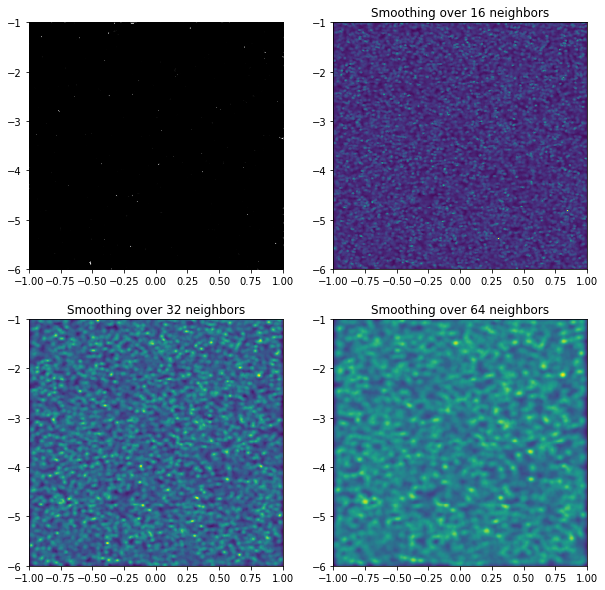

In [9]:

with open('./data/lr_64/l4/eval.p', 'rb') as f:
    data = pickle.load(f)
    cumR = np.expand_dims(np.sum(data['rewards'], axis=1), axis=1)
    pos = data['observations'][:,0,0:2]
    posR = np.concatenate((pos, cumR), axis=1)
    wh = np.where(data['rewards'][:,-1] == 0)[0]
    crash_posR = posR[wh,:]
#     fig, ax = plt.subplots()
#     ax.plot(crash_posR[:,0],crash_posR[:,1], 'bo')
#     ax.set_xlim(min(pos[:,0]),max(pos[:,0]))
#     ax.set_ylim(min(pos[:,1]),max(pos[:,1]))
    fig = plt.figure(1, figsize=(10,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    # # Generate some test data
#     x = np.random.randn(1000)
#     y = np.random.randn(1000)
    x = crash_posR[:,0]
    y = crash_posR[:,1]
#     z = crash_posR[:,2]
    z = None
    ax1.plot(x,y,'k.', markersize=5)
    ax1.set_xlim(-1,1)
    ax1.set_ylim(-6,-1)

    heatmap_16, extent_16 = myplot(x,y,z, nb=8)
    heatmap_32, extent_32 = myplot(x,y,z, nb=16)
    heatmap_64, extent_64 = myplot(x,y,z, nb=32)

    ax2.imshow(heatmap_16, extent=extent_16, origin='lower', aspect='auto')
    ax2.set_title("Smoothing over 16 neighbors")

    ax3.imshow(heatmap_32, extent=extent_32, origin='lower', aspect='auto')
    ax3.set_title("Smoothing over 32 neighbors")

    #Make the heatmap using a smoothing over 64 neighbors
    ax4.imshow(heatmap_64, extent=extent_64, origin='lower', aspect='auto')
    ax4.set_title("Smoothing over 64 neighbors")
    import pdb; pdb.set_trace()

--Return--
> <ipython-input-29-d49c443ac138>(44)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) c


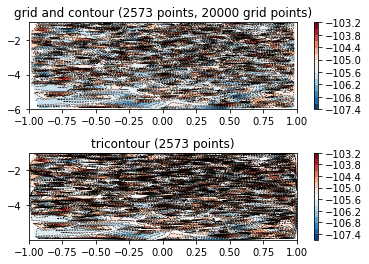

In [29]:
import matplotlib.tri as tri
import scipy.ndimage as ndimage
with open('./data/gen/g1/eval.p', 'rb') as f:
    data = pickle.load(f)
    cumR = np.expand_dims(np.sum(data['rewards'], axis=1), axis=1)
    pos = data['observations'][:,0,0:2]
    posR = np.concatenate((pos, cumR), axis=1)
    wh = np.where(data['rewards'][:,-1] == 0)[0]
    crash_posR = posR[wh,:]
    x = crash_posR[:,0]
    y = crash_posR[:,1]
    z = ndimage.gaussian_filter(crash_posR[:,2], sigma=10.0, order=0)
    npts = z.shape[0]
    # Create grid values first.
    ngridx = 100
    ngridy = 200
    xi = np.linspace(-1.0, 1.0, ngridx)
    yi = np.linspace(-6.0, -1.0, ngridy)
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    fig, (ax1, ax2) = plt.subplots(nrows=2)

    ax1.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
    cntr1 = ax1.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")

    fig.colorbar(cntr1, ax=ax1)
#     ax1.plot(x, y, 'ko', ms=3)
    ax1.axis((-1, 1, -6, -1))
    ax1.set_title('grid and contour (%d points, %d grid points)' %
                  (npts, ngridx * ngridy))


    ax2.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    cntr2 = ax2.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

    fig.colorbar(cntr2, ax=ax2)
#     ax2.plot(x, y, 'ko', ms=3)
    ax1.axis((-1, 1, -6, -1))
    ax2.set_title('tricontour (%d points)' % npts)

    plt.subplots_adjust(hspace=0.5)
    import pdb; pdb.set_trace()

In [10]:
from scipy.interpolate import griddata
with open('./data/lr_64/l4/eval.p', 'rb') as f:
    data = pickle.load(f)
    cumR = np.expand_dims(np.sum(data['rewards'], axis=1), axis=1)
    pos = data['observations'][:,0,0:2]
    posR = np.concatenate((pos, cumR), axis=1)
    wh = np.where(data['rewards'][:,-1] == 0)[0]
    crash_posR = posR[wh,:]
    grid_x, grid_y = np.mgrid[-1:1:10j, -6:-1:20j]
    interped = griddata(crash_posR[:,0:2],crash_posR[:,2],(grid_x, grid_y), method='nearest')
    heatmap = plt.imshow(interped, cmap='plasma', interpolation='spline16', extent=(-1,1,-6,-1), aspect=0.25)
    plt.colorbar(heatmap)

FileNotFoundError: [Errno 2] No such file or directory: './data/gen/g1/eval.p'

(49894,)


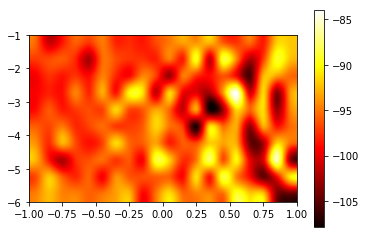

In [13]:
from scipy.interpolate import griddata
with open('./data/lr_64/l4/eval.p', 'rb') as f:
    data = pickle.load(f)
    cumR = np.expand_dims(np.sum(data['rewards'], axis=1), axis=1)
    pos = data['observations'][:,0,0:2]
    posR = np.concatenate((pos, cumR), axis=1)
    wh = np.where(data['rewards'][:,-1] == 0)[0]
    print(wh.shape)
    crash_posR = posR[wh,:]
    grid_x, grid_y = np.mgrid[-1:1:10j, -6:-1:20j]
    interped = griddata(posR[:,0:2],posR[:,2],(grid_x, grid_y), method='nearest')
    heatmap = plt.imshow(interped, cmap='hot', interpolation='spline16', extent=(-1,1,-6,-1), aspect=0.25)
    plt.colorbar(heatmap)
    

(106, 1)
(106, 2)


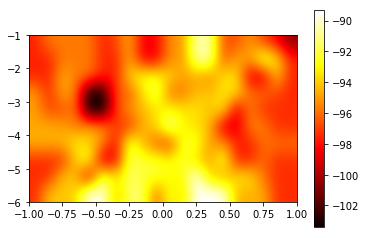

In [23]:
#Custom bucketing
from scipy.interpolate import griddata
with open('./data/lr_64/l4/eval.p', 'rb') as f:
    data = pickle.load(f)
    cumR = np.expand_dims(np.sum(data['rewards'], axis=1), axis=1)
    y = np.where((data['observations'][:,0,2] > 0.95) & (data['observations'][:,0,2] < 1.05) &
            (data['observations'][:,0,3] > 11) & (data['observations'][:,0,3] < 12) &
            (data['observations'][:,0,4] > 33) & (data['observations'][:,0,4] < 37))
    xx = cumR[y]
    pos = data['observations'][:,0,0:2][y]
    grid_x, grid_y = np.mgrid[-1:1:10j, -6:-1:20j]
    print(xx.shape)
    print(pos.shape)
    interped = griddata(pos[:,0:2],xx[:,0],(grid_x, grid_y), method='nearest')
    heatmap = plt.imshow(interped, cmap='hot', interpolation='bicubic', extent=(-1,1,-6,-1), aspect=0.25)
    plt.colorbar(heatmap)
# y = data['rewards'][(data['observations'][:,0,2] > 0.95) & (data['observations'][:,0,2] < 1.05)]
# y.shape


In [29]:
np.any((data['observations'][:,0,2] > 0.95) & (data['observations'][:,0,2] < 1.05))

True

In [5]:
with open('./data/lr_64/l1/eval.p', 'rb') as f:
    data = pickle.load(f)
    x = data['rewards']
    sum = np.sum()

dict_keys(['observations', 'actions', 'rewards', 'advantages', 'baselines', 'returns', 'valids', 'agent_infos', 'env_infos', 'paths', 'average_return'])


In [10]:
data['rewards'].shape

(50000, 50)

In [17]:
x = data['rewards']
x_sum = np.sum(x, axis = 1)

y = x[np.argmax(x_sum), :]
z = (np.exp(-1*y) - 1)
print(y)
print(z)

[-1.95943012 -2.2307499  -2.48204198 -2.04099334 -1.89838376 -1.68805186
 -2.34690151 -1.91751385 -2.37109747 -2.15450575 -2.29888933 -2.50660737
 -2.19828288 -2.52049101 -2.31263225 -2.00271108 -1.96301655 -1.99920624
 -2.23794327 -2.20129023 -2.52934831 -1.72944371 -2.53007538 -2.16432605
 -2.27025395 -2.53059818 -2.21168196 -2.51979921 -1.92168949 -2.40913909
 -1.87847972 -2.5221814  -1.87422984 -2.54827358 -2.51683179 -2.53783976
 -1.94791256 -2.5669346  -2.54226266 -2.52781097  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
[ 6.09528248  8.30684271 10.96567313  6.6982524   5.67509718  4.40893306
  9.45313062  5.80402159  9.70913882  7.62362688  8.96311059 11.26325472
  8.00952973 11.4347007   9.10097797  6.40911559  6.12077485  6.38319328
  8.37403157  8.03666533 11.54532782  4.63751695 11.55445246  7.70873069
  8.68185924 11.56101765  8.1310616  11.42610138  5.83249215 10.12437994
  5.54354924 11.45573799  5.51579898 11.7

In [25]:
from scipy.stats import multivariate_normal
a = data['actions']
x_mean = np.zeros((6))
x_cov = np.array([0.1, 0.01, 0.1, 0.1, 0.1, 0.1])
rv = multivariate_normal(mean=x_mean, cov=x_cov)
print(a[np.argmax(x_sum), :, :])
print(rv.pdf(a[np.argmax(x_sum), :, :]))

[[ 5.37200977e+00  4.13422382e-01  3.80732114e-01 -6.63698914e-01
  -6.99492854e-01  3.83633123e-01]
 [ 7.63206778e+00  6.58645129e-01 -1.64382439e+00  7.48021720e-01
   7.59817336e-01 -6.89546934e-01]
 [ 6.64693936e+00  1.28108414e+00 -9.03835771e-01 -7.30411560e-01
   1.54534789e+00 -8.71666952e-01]
 [ 5.54550608e+00 -2.67056561e-01  3.15919090e-01  4.41854891e-01
   1.09573352e+00  8.11981571e-01]
 [ 6.91668424e+00  6.70370443e-02  3.32996048e-01  3.96272820e-01
   1.52476576e+00 -1.18318203e-02]
 [ 6.06370064e+00  1.22171480e-01 -4.99324747e-01 -3.78521396e-01
   4.50008879e-01 -3.37425969e-01]
 [ 4.96756738e+00 -8.11138954e-01 -1.17482829e+00 -9.90974700e-01
   1.70135343e+00  1.94459651e-01]
 [ 6.35521675e+00 -1.82869647e-01 -1.41275867e+00  2.35803679e+00
   1.56666063e+00 -6.29845540e-01]
 [ 6.55070437e+00  7.36663944e-01 -1.98685239e+00  2.33696485e+00
   3.44229442e+00  1.04139982e+00]
 [ 6.90648810e+00 -5.89406676e-01 -3.23120896e-01 -5.46427992e-02
   3.40030937e+00 -1.8052

In [38]:
np.prod(rv.pdf(a[np.argmax(x_sum), :, :]))
a_plus = a[np.argmax(x_sum), :, :] + np.array([0.1, 0.01, 0.1, 0.1, 0.1, 0.1])
a_minus = a[np.argmax(x_sum), :, :] - np.array([0.1, 0.01, 0.1, 0.1, 0.1, 0.1])
pdf_plus = rv.pdf(a_plus)
pdf_minus = rv.pdf(a_minus)
print(-pdf_plus + pdf_minus)

[1.64817714e-066 9.18208994e-142 4.73581956e-138 2.74188283e-069
 2.44887124e-105 4.40071964e-079 2.05687075e-077 2.91164815e-107
 5.97390145e-148 5.34779906e-140 5.41716009e-104 1.09967901e-214
 4.89087262e-102 2.50952573e-214 8.91122606e-116 1.58573396e-101
 1.11834040e-103 1.15110915e-066 5.74129920e-064 1.40009372e-134
 4.31261009e-143 2.43281865e-070 5.01358454e-106 2.03578787e-056
 1.74636191e-134 2.58150492e-155 1.49019075e-095 7.51580636e-116
 1.40051501e-046 6.07435478e-102 2.52968367e-104 1.49550629e-176
 2.03809535e-053 5.31592468e-167 1.34894139e-115 1.53558905e-109
 9.98143943e-029 1.01828523e-097 1.53821825e-153 3.45401590e-096
 1.88737247e-069 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


In [33]:
t = np.sqrt(-2*np.log(1e-7))
print(t)

5.67769242755511
